# 冯康与哈密顿系统的辛几何算法

庞龙刚@华中师范大学

## 学习内容

- 冯康是谁
- 什么是哈密顿系统
- 什么是辛算法 (Symplectic Algorithm)
- 常微分方程的传统解法

In [27]:
%matplotlib inline

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np

# odeint 用于求解常微分方程
from scipy.integrate import odeint

plt.style.use(['science', 'notebook', 'no-latex'])

## 冯康是谁

冯康（1920-1993）是中国科学院院士，计算数学奠基人。

美籍华人数学家、菲尔兹奖获得者丘成桐说：“中国近代数学能超越西方或与之并驾齐驱的主要原因有三个，

一个是陈省身在示性类方面的工作，

一个是华罗庚在多复变函数方面的工作，

一个是冯康在有限元计算方面的工作。”

冯康除了独立西方提出有限元算法外，还有一项不太被人知道的成就：

**哈密尔顿系统的辛几何算法**，被追授为“1997年国家自然科学奖一等奖”。

详细参考：
1. 《冯康传》
2. 《Symplectic Geometry Algorithms for Hamiltonian Systems》, by Kang Feng, Mengzhao Qin

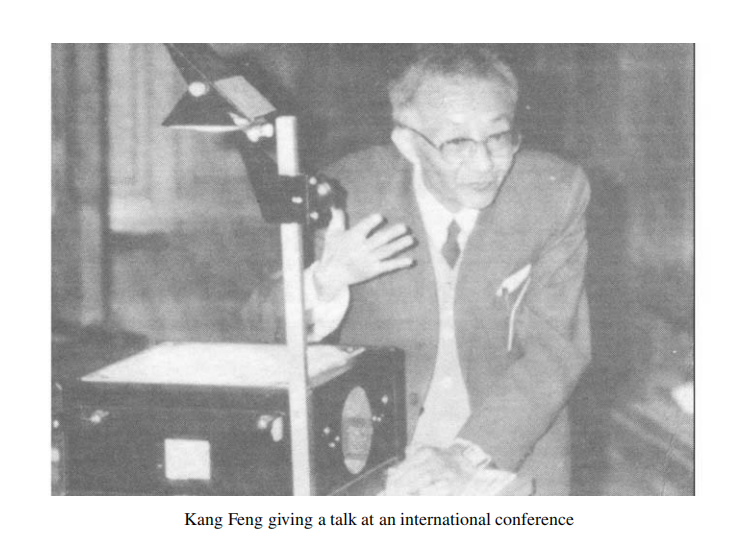

In [28]:
Image("images/fengkang_photo.png", height="500") 

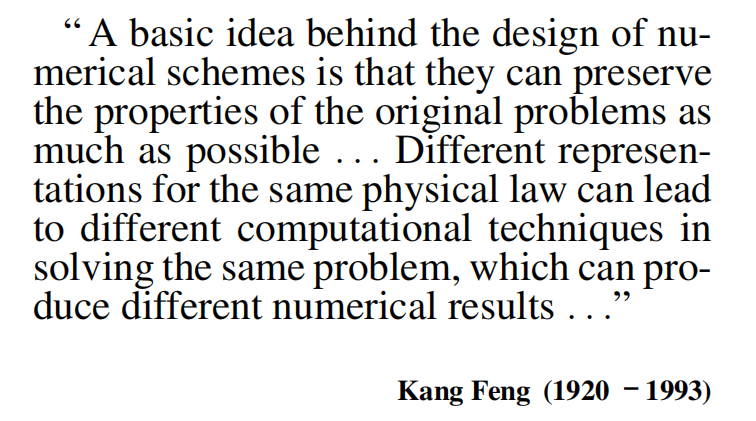

In [29]:
Image("images/fengkang_words.png", height="500")

# 数值解需要尽量遵从问题本身的对称性和守恒律
# 物理定律有各种各样的表示和计算方法
# 不同的计算方法可能产生不同的数值结果
# 接下来以哈密顿系统和辛几何算法展示这段话的含义

## 什么是哈密顿 (Hamilton) 系统

哈密顿系统是耗散可忽略不计的真实物理系统，无论它是经典的、量子的、相对论性的、有限维还是无限维的系统。

哈密顿系统的演化满足两类守恒律，

1. 能量守恒、动量守恒、角动量守恒
2. 相空间（坐标、动量）的面积守恒（Liouville–Poincar´e conservation law）

举例：行星系统，双原子分子的经典轨道，封闭量子系统(closed quantum system)，无阻尼谐振子

在冯康之前，很少有人考虑两个问题，（1）. 现有的数值算法是否适用于哈密顿系统
（2）. 如果不适用，如何构造适用于哈密顿系统的数值算法

比如，为了计算行星轨道，需要数值求解如下哈密顿运动方程，其中哈密顿量为 $H = T + V$。

\begin{align}
{d q \over dt} &=  {\partial H \over \partial p} \\
{d p \over dt} &= - {\partial H \over \partial q} 
\end{align}

如果需要模拟几十万年的时间，数值计算结果能否真正反映物理现实。

如果因为数值耗散，导致行星逐渐坠入太阳，或逐渐脱离太阳系，我们能否信任这样的模拟结果？

如何构造“干净”的数值算法，使得数值求解过程满足哈密顿系统的两类守恒律？

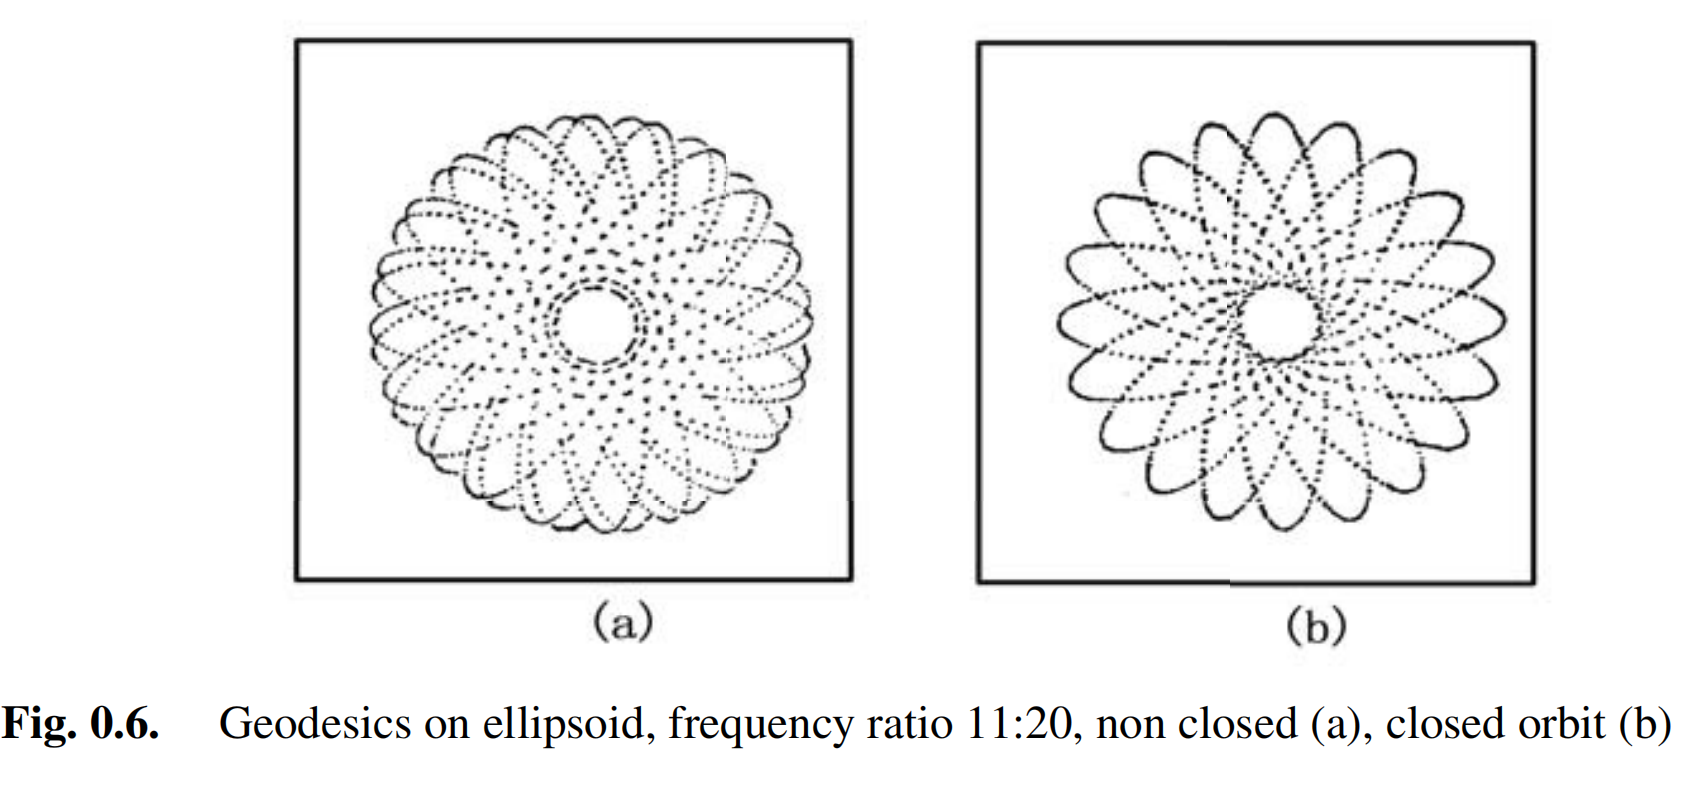

In [30]:
Image("images/kapler_symplectic.png")
# 开普勒系统：行星轨道 
# (a) 传统算法，行星轨道不封闭，
# (b) 辛几何算法， 稳定封闭轨道

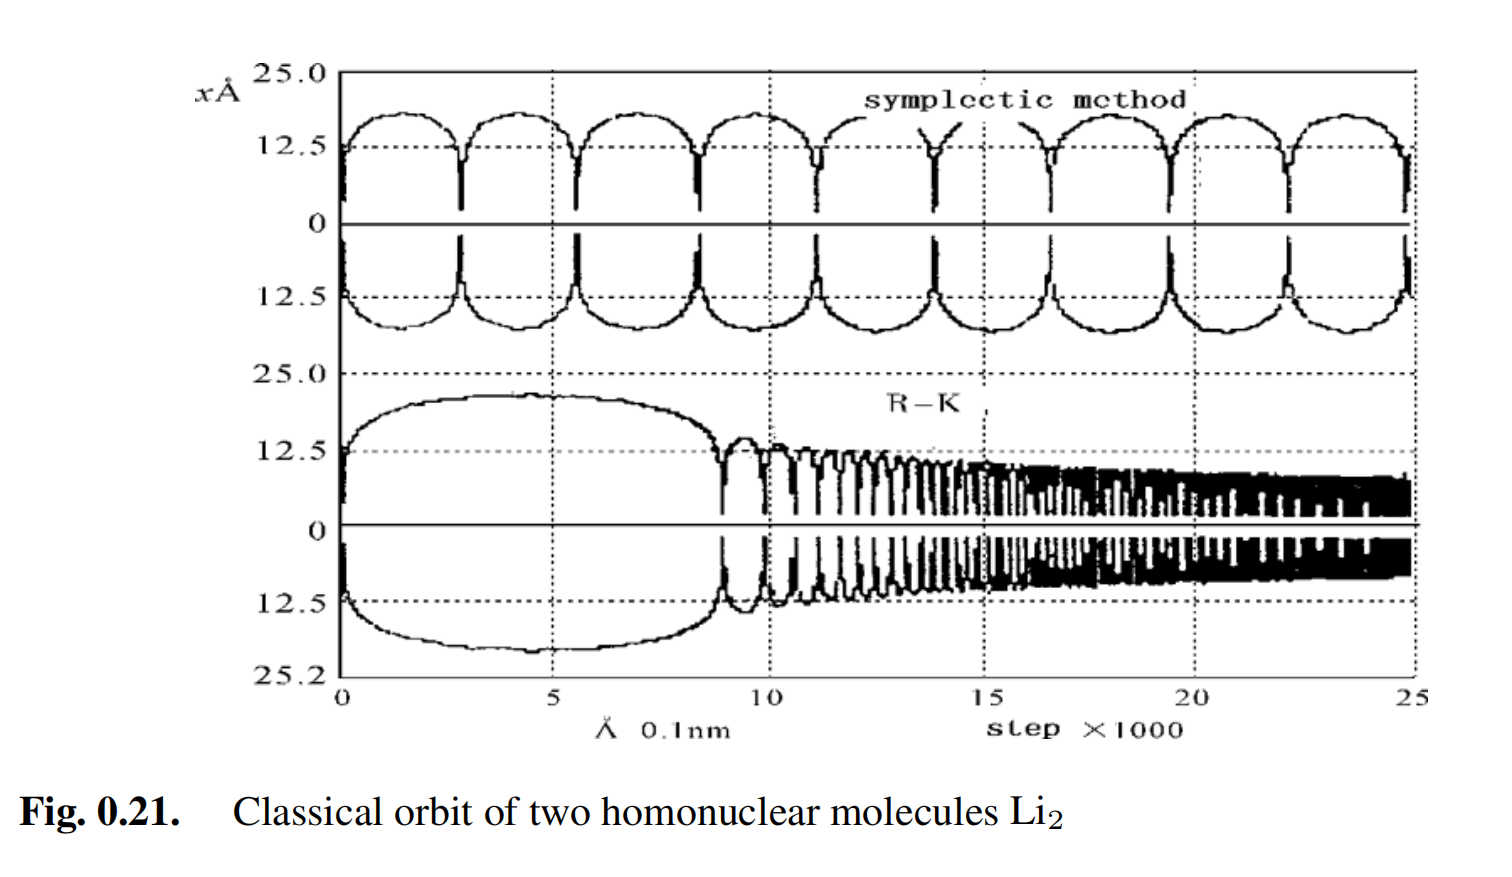

In [31]:
Image("images/Li2.png")
# Li2 双原子系统的经典轨道
# 第一行为辛算法(symplectic method), 长时稳定，振幅，周期性，总能量，相轨道都保持良好
# 第二行为龙格库塔(R-K) 算法， 5000 个时间步之后振幅变小，总能量下降

举例：**无阻尼谐振子** 

假设地面无限光滑，弹簧无热耗散。

<img src="images/harmonic_oscillator.jpeg"></img>

如果拉伸弹簧后松开，方块儿会永不停歇的做简谐振动。

这个最简单的谐振子系统的哈密顿量为，

$H = {p^2 \over 2 m } + {k q^2 \over 2}$

其中 
- $p$ 是方块儿的动量，
- $m$ 是方块儿的质量，
- $k$ 是弹簧的弹性系数，
- $q$ 是方块儿位移，表示弹簧拉伸或压缩的长度，有时候也用 $x$ 表示。

定义弹簧拉伸/压缩长度为 0 时，方块的坐标 $q=0$。

经典力学哈密顿量可以看做是给定状态下系统的能量，等于动能 $T(q)$ 加势能 $V(q)$。

$E = T(p) + V(q) = {p^2 \over 2 m } + {k q^2 \over 2}$

将 E 除到右边，上面方程表现出很奇特的性质，

$  {p^2 \over 2 m E } + {k q^2 \over 2 E} = 1$

如果设 $a^2 = 2 m E$, $b^2 = 2E/k$, 上面的方程变为，

$  {p^2 \over a^2 } + {q^2 \over b^2} = 1$

这是一个椭圆的轨迹方程。


即坐标和动量$(q, p)$ 轨道在相空间中是一个等能量的椭圆！

如果推广到高维系统，就是等能面。有些地方也把它叫做叫“辛流形” （Symplectic Manifold）。

下面先画一下理想情况下方块儿的相空间（坐标，动量）轨迹，选择两个不同的弹性系数 $k$。

将 $q, p$ 重新参数化为，

\begin{align}
q = b \cos \theta \\
p = a \sin \theta 
\end{align}

可以看到它们满足 $  {p^2 \over a^2 } + {q^2 \over b^2} = 1$。 不同的 $\theta$ 对应相空间不同的点。

In [32]:
def phase_flow(E, mass, k, theta=0):
    '''产生等能面上的初始条件 (q, p)
    :E: 能量，>0
    :mass: 质量 >0
    :k: 弹簧弹性系数 > 0
    :return: (q, p) 相轨（相流）的解析解'''
    a = np.sqrt(2 * mass * E)
    b = np.sqrt(2 * E / k)
    
    q = b * np.cos(theta)
    p = a * np.sin(theta)

    return q, p

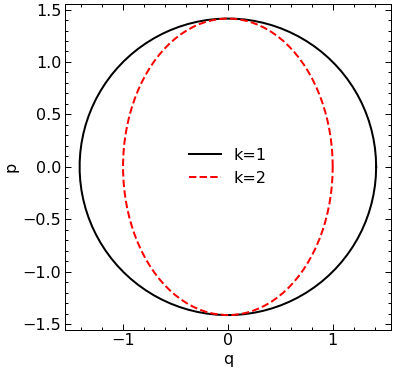

In [33]:
# 绘制理想情况下方块儿在相空间中的轨迹
# （q, p) 表示方块儿的位移与动量，对于不同的弹簧弹性系数，相空间轨迹是不同的椭圆。
# 下面这两个相空间轨迹分别对应能量 E=1, 质量 m=1， 弹性系数 k=1 和 2。
# 我们希望数值解出的 (q, p) 也在这个等能面上，无论模拟的时间有多长。

theta = np.linspace(0, 2*np.pi, 100)
q1, p1 = phase_flow(E=1, mass=1, k=1, theta=theta)
q2, p2 = phase_flow(E=1, mass=1, k=2, theta=theta)
plt.plot(q1, p1, 'k-', label="k=1")
plt.plot(q2, p2, 'r--', label="k=2")
plt.xlabel('q')
plt.ylabel('p')
plt.legend(loc='best')
plt.gca().set_aspect('equal')

从哈密顿量可以得到运动方程，


${d q \over dt} =  {\partial H \over \partial p}= {p \over m}$

${d p \over dt} = - {\partial H \over \partial q} = - k q$

这两个方程分别是小球的速度和动量（加速度）满足的时间演化方程。



简单起见，设 $m=1, k=1$, 写成矩阵的形式，

${d \over d t} \begin{bmatrix} q \\ p \end{bmatrix} =  \begin{bmatrix} p \\ -q \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix}  \begin{bmatrix} q \\ p \end{bmatrix} $

这种 $J =  \begin{bmatrix} 0 & I \\ -I & 0 \end{bmatrix}$ 斜对角矩阵是一个非常有意思的结构，

正交矩阵 R 定义为满足 $R^T R = R^T I R = I$ 的实矩阵，它们是 $O(n)$ 群的群元。

可以证明所有满足 $M^T J M = J$ 的 2n*2n 的实矩阵(或称变换）$M$ 也构成一个群，这个群叫辛群, 记为 Sp(2n, R)。

证明满足 $M^T J M = J$ 的所有 2n*2n 实矩阵 $M$ 构成一个群需要证明，

- 存在单位元 : 2n*2n 的单位矩阵 I 满足 $I^T J I = J$
- 存在逆元: 如果 M 是这个群的元素，即 $M^T J M=J$, 则 $(M^{-1})^{T} J M^{-1} = (M^{-1})^{T} M^T J M M^{-1} = (M M^{-1})^T J (M M^{-1}) = I^T J I = J$, 说明 $M^{-1}$ 也是这个群的元素。
- 如果 $M_1$, $M_2$ 分别是这个群的元素，则$M_1 M_2$ 也是这个群的元素。

\begin{align}
M_1^T J M_1 &= J \\
M_2^T J M_2 &= J
\end{align}
由上面两个条件推导出，
\begin{align}
J = M_2^T J M_2 &= M_2^T M_1^T J M_1 M_2 = (M_1 M_2)^T J (M_1 M_2)
\end{align}
即 $M_1M_2$ 也是这个群的元素。注：推导过程多处用到 $(A B)^T = B^T A^T$

为了保证数值解不会因为误差累积而偏离等能面，需要数值离散格式的每一步更新变换矩阵 $M$ （或称雅克比矩阵）是辛群的一个元素。

$M = {\partial (q^*, p^*)\over\partial (q, p)} = \begin{bmatrix} {\partial q^* \over \partial q} & {\partial q^* \over \partial p} \\
 {\partial p^* \over \partial q} & {\partial p^* \over \partial p}
\end{bmatrix}$ 

即 $M^T J M = J$ 成立表示数值离散格式是“保辛算法”。


### 显式欧拉法 （Explicit Euler)

首先检查不用辛几何算法，而是使用显式欧拉法 （Explicit Euler)解谐振子问题，会得到何种结果。

设 $y=\begin{bmatrix} q \\ p \end{bmatrix}$, $f(y, t)=\begin{bmatrix} p \\ -q \end{bmatrix}$, 则运动方程${d \over d t} \begin{bmatrix} q \\ p \end{bmatrix} =  \begin{bmatrix} p \\ -q \end{bmatrix} $可以写为标准的**常微分方程形式**

\begin{align}
{d y \over dt} = f(y, t)
\end{align}

显式欧拉法做向前差分近似  ${dy \over dt} \approx {y^{n+1} - y^n \over h}$ ，则常微分方程离散化为，

\begin{align}
y^{n+1} = y^{n} + h f(y^n, t_0 + n h)
\end{align}

其中 $y^n$ 表示第 n 个时间步时 y 的值，时间步长 $ h = \Delta t$.

In [34]:
# 第一步：为了求解常微分方程，我们首先需要设定初始条件 
# 设 t=0 时，方块儿位移最大， q = b cos(theta=0) = b

q0, p0 =  phase_flow(E=1, mass=1, k=1, theta=0) 
print("初始条件:(q, p)=(%.2f, %.2f)"%(q0, p0))

初始条件:(q, p)=(1.41, 0.00)


In [35]:
# 第二步：按照 Explicit Euler 格式更新方块儿的坐标和动量
# 先定义 dy/dt = f 的右边， f = [p, -q]^T

def f(y, t):
    '''
    :y: 广义坐标与动量 [q, p] 
    :return: 运动方程 [p, -q]'''
    return np.array([y[1], -y[0]])

def explicit_euler(f, y0, t):
    '''显式欧拉法计算相空间轨迹 
    :f: 函数 f(y, t), 常微分方程dy/dt = f 的右边
    :y0: 初始条件， y(t[0])
    :t: np.array(), 长度等于时间步数
    :return: 常微分方程的解 '''
    dt = t[1] - t[0]
    sol = [y0]
    y = y0
    for ti in t[1:]:
        y = y + dt * f(y, ti)
        sol.append(y)
    
    return np.array(sol)    

The shape of the solution is: (10000, 2)


Text(0, 0.5, 'q')

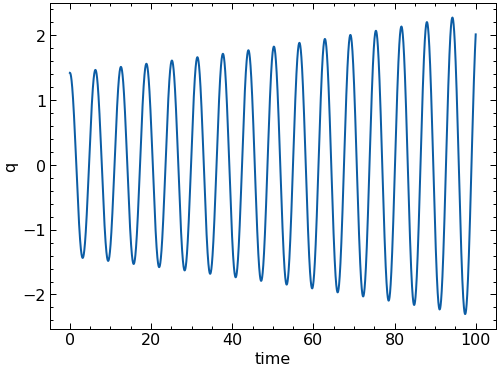

In [36]:
y0 = np.array([q0, p0])
tmax, nsteps = 100, 10000
t = np.linspace(0, tmax, nsteps)
# sol 是显式欧拉法求解结果
sol = explicit_euler(f, y0, t)
print("The shape of the solution is:", sol.shape)

plt.plot(t, sol[:, 0])
plt.xlabel("time")
plt.ylabel("q")
# 显式欧拉法： 谐振子的振幅越来越大，不符合物理现实！

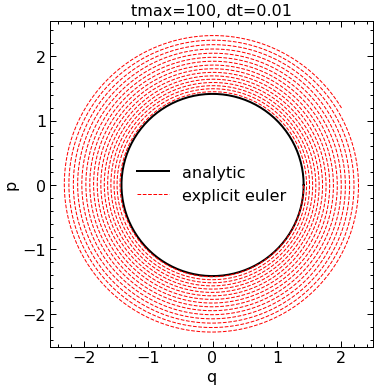

In [37]:
def plot_phase_flow(sol, title="tmax=100, dt=0.01", style='k-', label=''):
    q = sol[:, 0]
    p = sol[:, 1]
    plt.plot(q, p, style, lw=1, label=label)
    plt.xlabel('q')
    plt.ylabel('p')
    plt.title(title)
    plt.gca().set_aspect('equal')
theta = np.linspace(0, 2*np.pi, 100)
q1, p1 = phase_flow(E=1, mass=1, k=1, theta=theta)
plt.plot(q1, p1, 'k-', label="analytic")
plot_phase_flow(sol, style='r--', label='explicit euler')
plt.legend(loc='best')

### 举例：判断显式欧拉法离散格式的变换矩阵是否为辛群的元素

对于之前的问题，
\begin{align}
{d \over d t} \begin{bmatrix} q \\ p \end{bmatrix} =  \begin{bmatrix} p \\ -q \end{bmatrix} 
\end{align}
将上述运动方程离散化后，得到更新变换，

\begin{align}
 q^{n+1} =  q^n + h\ p^n \\ p^{n+1} = p^n -h\ q^n
 \end{align}
 
 更新变换矩阵为，
 \begin{align}
 M = {\partial (q^{n+1}, p^{n+1})\over\partial (q^n, p^n)} = \begin{bmatrix} 1 & h \\ -h &1 \end{bmatrix}
  \end{align}
  可以简单验证 $M^T J M \neq J$, 对于此问题，显式欧拉法离散格式不是保辛格式。

In [38]:
from sympy import Matrix
from sympy import symbols
import sympy as sym

h = symbols("h") 
M = Matrix([[1, h], [-h, 1]])
J = Matrix([[0, 1], [-1, 0]])

M.T @ J @ M

Matrix([
[        0, h**2 + 1],
[-h**2 - 1,        0]])

In [39]:
# 雅可比矩阵的行列式表示变换后相空间体积的增大倍数
# 保辛算法的另一个特点： det(M)**2 = 1
# 显式欧拉法的 det(M)**2 > 1, 所以振幅越来越大

M.det()**2

(h**2 + 1)**2

但是对于某些问题，显式欧拉法又是保辛格式，比如，假设存在如下常微分方程组，

\begin{align}
{dq \over dt} &= 0  \\
 {dp \over dt} &= f(q)
\end{align}

离散化格式为，
\begin{align}
q^{n+1} &= q^n \\
p^{n+1} &= p^n + h f(q^n) 
\end{align}

更新变换矩阵为，
\begin{align}
M &= {\partial (q^{n+1}, p^{n+1})\over\partial (q^n, p^n)} = \begin{bmatrix} 1 & 0 \\ h f'(q) &1 \end{bmatrix} = \begin{bmatrix} 1 & 0 \\ a &1 \end{bmatrix}
\end{align}
其中，最后一步我们设 $ h f'(q)=a$。

In [40]:
a = symbols("a") 
M = Matrix([[1, 0], [a, 1]])

M.T @ J @ M

Matrix([
[ 0, 1],
[-1, 0]])

In [41]:
M.det()**2 

1

对于特定的问题，判断 M 是否是辛群的元素，从而可以知道离散化格式是否保辛。

这是群论在数值计算稳定性判断中的重要应用。

## 最简单的辛欧拉算法

对于动能与势能可分的哈密顿量，存在一个非常简单的辛欧拉离散化格式。只需要在原始的欧拉算法上做个微调，

\begin{align}
q^{n+1} &=  q^n + h\ p^{n+1} \\ 
p^{n+1} &= p^n -h\ q^n
 \end{align}
 
这里相当于隐式的使用下一时刻的动量 $p^{n+1}$ 更新坐标 $q^{n+1}$。 将第一式中 $p^{n+1}$ 移到左边，将第二式乘以 h，与第一式相加，

\begin{align}
q^{n+1} - h p^{n+1} &=  q^n  \\ 
h p^{n+1} &= h p^n -h^2\ q^n
 \end{align}

得到更新步骤，

\begin{align}
q^{n+1} &= (1- h^2) q^n + h p^n \\ 
p^{n+1} &= - h q^n + p^n
 \end{align}

写成矩阵形式，

\begin{align}
y^{n+1} = M y^n = \begin{bmatrix} 1-h^2 & h \\ -h  &1 \end{bmatrix}\begin{bmatrix} q^n  \\ p^n \end{bmatrix} 
\end{align}

此时更新变换矩阵为，
 \begin{align}
 M = {\partial (q^{n+1}, p^{n+1})\over\partial (q^n, p^n)} = \begin{bmatrix} 1-h^2 & h \\ -h &1 \end{bmatrix}
  \end{align}
  
 可以简单验证 $M^T J M = J$, 从而证明这种格式确实为辛欧拉格式。

In [42]:
M = Matrix([[1-h*h, h], [-h, 1]])

M.T@J@M

Matrix([
[ 0, 1],
[-1, 0]])

In [43]:
M.det()

1

In [44]:
#接下来我们使用“辛欧拉算法测试谐振子问题
def symplectic_euler(f, y0, t):
    '''辛欧拉算法计算相空间轨迹 
    :f: 函数 f(y, t), 常微分方程dy/dt = f 的右边
    :y0: 初始条件， y(t[0])
    :t: np.array(), 长度等于时间步数
    :return: 常微分方程的解 '''
    h = t[1] - t[0]
    sol = [y0]
    q, p = y0
    for ti in t[1:]:
        p = p - h * q
        q = q + h * p
        sol.append([q, p])
    
    return np.array(sol)  

The shape of the solution is: (10000, 2)


Text(0.5, 1.0, 'Symplectic Euler Method')

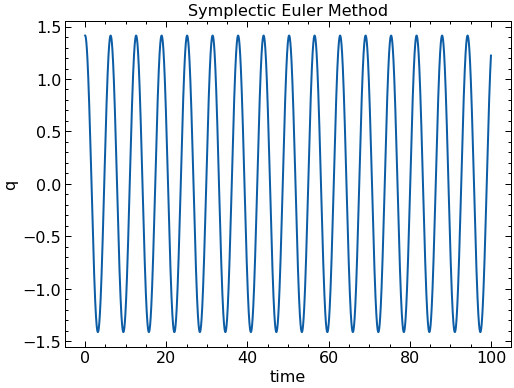

In [45]:
sol = symplectic_euler(f, y0, t)

print("The shape of the solution is:", sol.shape)
plt.plot(t, sol[:, 0])
plt.xlabel("time")
plt.ylabel("q")
plt.title("Symplectic Euler Method")
# 辛欧拉法： 谐振子的振幅保持恒定

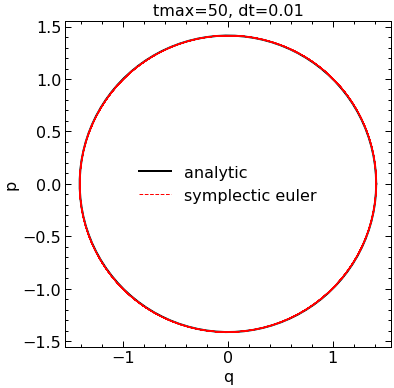

In [46]:
plt.plot(q1, p1, 'k-', label="analytic")
plot_phase_flow(sol, title="tmax=50, dt=0.01", style='r--', label='symplectic euler')
plt.legend(loc='best')

## 欧拉中点辛算法

有些书上介绍了另一种方法 -- 欧拉中点法，算法步骤如下，

设 $y = \begin{bmatrix} q \\ p \end{bmatrix}$, 如果 Hamilton 矩阵可以写成 $y$ 的二次型，即 

\begin{align}
H = {1 \over 2}y^T C y
\end{align}
且 $C^T = C$, 则存在一个简单的辛欧拉公式，

\begin{align}
y^{n+1} &= M y^n \\
M &= \left( 1 - {h \over 2}B \right)^{-1} \left( 1 + {h \over 2}B \right)
\end{align}

其中 $B = J C$。


很明显之前的谐振子例子满足辛欧拉算法的使用条件，

$ C = \begin{bmatrix} 1 & 0 \\ 0 & 1\end{bmatrix}$,

$ H = {1 \over 2}  \begin{bmatrix} q^T & p^T \end{bmatrix} \begin{bmatrix} 1 & 0 \\ 0 & 1\end{bmatrix} \begin{bmatrix} q \\ p \end{bmatrix} = {1 \over 2}y^T C y$,

$ B = J C = \begin{bmatrix} 0 & 1 \\ -1 & 0\end{bmatrix} \begin{bmatrix} 1 & 0 \\ 0 & 1\end{bmatrix} = J $ 

In [47]:
B = J

I22 = Matrix([[1, 0], [0, 1]])
M = (I22 - h/2 * B).inv() @ (I22 + h/2 * B)
M = sym.simplify(M)
M

Matrix([
[(4 - h**2)/(h**2 + 4),        4*h/(h**2 + 4)],
[      -4*h/(h**2 + 4), (4 - h**2)/(h**2 + 4)]])

In [48]:
sym.simplify(M.det())
# 保相空间体积

1

In [49]:
sym.simplify(M.T @ J @ M)
# 可以看到 M.T@J@M == J，保辛

Matrix([
[ 0, 1],
[-1, 0]])

这个辛欧拉格式的得出过程为，

\begin{align}
\dot{y} &= {d y \over dt} \\
&= J {\partial_y H } = J { \partial_y \left({1 \over 2}y^T C y \right)} \\
&= JC y = B y
\end{align}

然后使用欧拉中点法，

\begin{align}
y^{n+1} - y^n = {h B \over 2}  (y^{n+1} + y^n) 
\end{align}

即可得到步进公式， $M = \left( 1 - {h \over 2}B \right)^{-1} \left( 1 + {h \over 2}B \right)$。

实际使用中发现此格式对谐振子问题并不友好，同学们可以寻找一下公式推导中是否有 bug。

## 常微分方程的常规解法：龙格库塔

如果是短时模拟，或者求解的系统不是哈密顿系统（有时也称保守系统），最常用的解常微分方程的方法是龙格库塔（Runge-Kutta 法）。

对于常微分方程，
\begin{align}
{d y \over dt} = f(y, t)
\end{align}

Runge-Kutta 方法使用区间 $[t^n, t^{n+1}]$ 上多个点的梯度 $f$ 得到一个平均梯度，来提高数值求解精度，

\begin{align}
y^{n+1} = y^n + h \sum_{i=1}^L \lambda_i k_i
\end{align}

比如，Runge-Kutta 算法中最常用的 4 级 4 阶公式，可以展开为，

\begin{align}
y^{n+1} &= y^n + {h \over 6}(k_1 + 2k_2 + 2k_3 + k_4) \\
k_1 &= f(t^n, y^n) \\
k_2 &= f(t^n + {h \over 2}, y^n + {h \over 2} k_1) \\
k_3 &= f(t^n + {h \over 2}, y^n + {h \over 2} k_2) \\
k_4 &= f(t^n + h, y^n + h k_3)
\end{align}

练习：可以尝试实现 4 阶 Runge-Kutta 公式，并与显式欧拉法结果对比。

一般情况下，并不需要我们自己实现 Runge-Kutta 算法，Python，Mathematica 或者 Matlab 中都有成熟的实现。

## 动画对比不同算法求解哈密顿系统的常微分方程

<IPython.core.display.Javascript object>


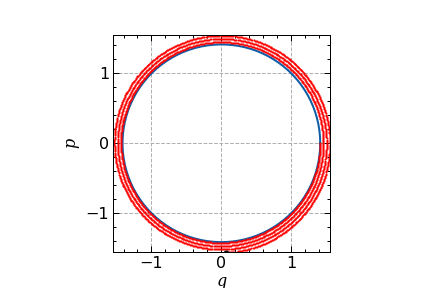

In [51]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

tmax = 20
tsteps = 1000
dt = tmax / tsteps

sol = explicit_euler(f, y0, t)
#sol = odeint(f, y0, t)
#sol = symplectic_euler(f, y0, t)

def update(i):
    q = sol[0 : i, 0]
    p = sol[0 : i, 1]
    line1.set_data(q, p)
    line2.set_data(sol[i, 0], sol[i, 1])
    text.set_text(r'$t=%.2f$'%(i*dt))
    return line1, line2, text,

fig1, ax1 = plt.subplots()

# 画等能面，数值解要在等能面上
theta = np.linspace(0, 2*np.pi, 100)
q_ana, p_ana = phase_flow(1, 1, 1, theta)
plt.plot(q_ana, p_ana)

# 画历史轨迹
line1, = plt.plot(sol[0, 0], sol[0, 1], 'ro', ms=1)

# 画当前相空间位置
line2, = plt.plot(sol[0, 0], sol[0, 1], 'ko', ms=5)

text = plt.text(-6, 6, '')

#plt.title("Symplectic Euler Method")

plt.grid(ls="--")

plt.ylabel(r'$p$')

plt.xlabel(r'$q$')

plt.gca().set_aspect('equal')

anim1 = FuncAnimation(fig1, update, frames=10000, interval=10, blit=False)
#anim1.save('images/symplectic_euler_anim.mp4')

#plt.show()